In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from patsy import bs
import cv2
%matplotlib inline

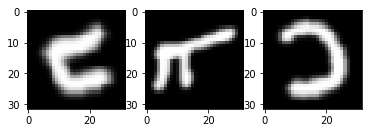

In [7]:
letter_data = np.load("letter_data.npy")
mask = range(7000, 10000)
letter_val = letter_data[mask]
mask = range(7000)
letter_train = letter_data[mask]

IMG_SIZE = 32
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,1)
def format_images(images):
    res = np.zeros([images.shape[0], IMG_SIZE, IMG_SIZE])
    for i in range(images.shape[0]):
        res[i,:,:] = cv2.resize(images[i,:,:], (IMG_SIZE, IMG_SIZE))
        res[i,:,:] /= np.sum(res[i,:,:])
    res = np.reshape(res,[-1,IMG_SIZE,IMG_SIZE,1])
    return np.asarray(res,dtype=np.float32)

show = format_images(letter_data[:10,:,:])
plt.figure(1)
plt.subplot(131)
plt.imshow(show[1,:,:,0], cmap='gray')
plt.subplot(132)
plt.imshow(show[5,:,:,0], cmap='gray')
plt.subplot(133)
plt.imshow(show[7,:,:,0], cmap='gray')
plt.show()

In [3]:
def reconstruction_xy(loc, moment, section=3, num_points=30):
    """Using position and moments to reconstruct points on curve"""
    M = tf.constant([[1,0,0,0],[1,1,1,1],[0,1,0,0],[0,1,2,3]], dtype=tf.float32)
    M = tf.transpose(tf.linalg.inv(M))
    t_value = np.linspace(0,1, num = section+1)
    tpoints = np.linspace(0, 1, num=num_points)
    basis = np.vstack([tpoints**0, tpoints**1, tpoints**2, tpoints**3])
    v_basis = np.vstack([0*tpoints**0, 1*tpoints**0, 2*tpoints, 3*tpoints**2])
    basis = tf.constant(basis, dtype=tf.float32)
    v_basis = tf.constant(v_basis, dtype=tf.float32)
    
    i = 0
    x_i = tf.gather(loc, [i,i+1], axis=1)
    m_i = tf.gather(moment, [i,i+1], axis=1)
    xm_i = tf.concat([x_i, m_i], 1)
    coeff = tf.matmul(xm_i, M)
    curve = tf.matmul(coeff, basis)
    deriv = tf.matmul(coeff, v_basis)
    ### consequent intervals
    for i in range(1, section+1):
        x_i = tf.gather(loc, [i,i+1], axis=1)
        m_i = tf.gather(moment, [i,i+1], axis=1)
        xm_i = tf.concat([x_i, m_i], 1)
        coeff_i = tf.matmul(xm_i, M)
        curve_i = tf.matmul(coeff_i, basis)
        deriv_i = tf.matmul(coeff_i, v_basis)
        coeff = tf.concat([coeff, coeff_i], 1)
        curve = tf.concat([curve, curve_i], 1)
        deriv = tf.concat([deriv, curve_i], 1)
    return curve, deriv, coeff

def reconstruction(loc, moment, section=3, num_points=30):
    x_points, dx, x_coeff = reconstruction_xy(loc[:,:,0], moment[:,:,0], section, num_points)
    y_points, dy, y_coeff = reconstruction_xy(loc[:,:,1], moment[:,:,1], section, num_points)
    velocity = tf.sqrt(dx**2 + dy**2)
    return x_points, y_points, velocity, x_coeff, y_coeff

def kernel_image(x_points, y_points, velocity, sig2):
    index_tensor = np.zeros([IMG_SIZE,IMG_SIZE,2], dtype=np.float32)
    for i in range(IMG_SIZE):
        for j in range(IMG_SIZE):
            index_tensor[i,j,:] = [i/(IMG_SIZE-1.0), j/(IMG_SIZE-1.0)]
    locations = tf.constant(index_tensor)
    points = tf.stack([x_points, y_points], axis=2)
    dist = tf.einsum("iju,ntu->nijt", locations**2, tf.ones_like(points)) -\
           2 * tf.einsum("iju,ntu->nijt", locations, points) +\
           tf.einsum("iju,ntu->nijt", tf.ones_like(locations), points**2)
    kernel = tf.exp(-0.5*tf.einsum("nijt,n->nijt", dist, sig2**(-1)))
    kernel = tf.einsum("nijt,nt->nijt", kernel, velocity)
    images = tf.reduce_sum(kernel, axis=3)
    tweights = tf.reduce_sum(images, axis=[1,2])
    images = tf.einsum("nij,n->nij", images,tweights**(-1))
    return images

def loss(images, kernel_img):
#     return tf.reduce_mean(-images*tf.math.log(kernel_img))
    return tf.reduce_mean(
            tf.reduce_sum(tf.math.abs(images-kernel_img), axis=[1,2])
           )

1.0000001


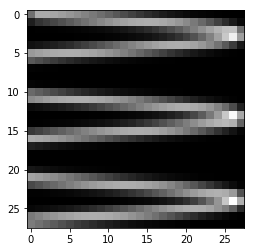

In [4]:
xpo = np.linspace(0,1,num=1000, dtype=np.float32)
ypo = np.sin(16*xpo, dtype=np.float32)
vx = np.ones_like(xpo)
vy = 16*np.cos(16*xpo, dtype=np.float32)
v = np.sqrt(vx**2+vy**2)
sig2 = np.array([5e-4],dtype=np.float32)
xx = kernel_image(tf.constant(np.reshape(xpo,[1,-1])), 
                  tf.constant(np.reshape(ypo,[1,-1])),
                  tf.constant(np.reshape(v,[1,-1])),
                  tf.constant(sig2))
print(np.sum(xx.numpy()))
plt.imshow(xx.numpy()[0,:,:], cmap="gray")
plt.show()

In [14]:
def coding_net(num_filter=32, section=3, lam=1e-3, std=1):   
    reg = keras.regularizers.l2(l=lam)
    init = keras.initializers.RandomNormal(stddev=std)
    init2 = keras.initializers.RandomNormal(stddev=std/10)
    inputs = keras.Input(shape=IMG_SHAPE, name="input_image")
    # First Convolution layers
    conv1 = layers.Conv2D(filters=num_filter,
                          kernel_size=[5,5],
                          padding="same",
                          kernel_regularizer=reg,
                          activation=tf.nn.relu6)(inputs)
    batch1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPool2D(pool_size=[2,2],strides=2)(batch1)
    dropout1 = layers.Dropout(0.9)(pool1)
    # Second Convolution layers
    conv2 = layers.Conv2D(filters=num_filter*2,
                          kernel_size=[5,5],
                          padding="same",
                          kernel_regularizer=reg,
                          activation=tf.nn.relu6)(dropout1)
    batch2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPool2D(pool_size=[2,2],strides=2)(batch2)
    dropout2 = layers.Dropout(0.7)(pool2)
    # Second Convolution layers
    conv3 = layers.Conv2D(filters=num_filter*4,
                          kernel_size=[5,5],
                          padding="same",
                          kernel_regularizer=reg,
                          activation=tf.nn.relu6)(dropout2)
    batch3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPool2D(pool_size=[2,2],strides=2)(batch3)
    dropout3 = layers.Dropout(0.5)(pool3)
    
    drop3_flat = tf.reshape(dropout3, [-1, int(IMG_SIZE*IMG_SIZE*num_filter/16)])
    dense = layers.Dense(1024, activation=tf.nn.relu,
                         kernel_regularizer=reg)(drop3_flat)
    dropout4 = layers.Dropout(0.5)(dense)
    
    loc = layers.Dense((section+1)*2, 
                        activation = tf.nn.sigmoid,
                        bias_initializer=init,
                        kernel_regularizer=reg)(dropout4)
    delta_moment = layers.Dense((section+1)*2, 
                                kernel_regularizer=reg)(dropout4)
    sig2 = layers.Dense(1,activation=tf.nn.tanh,
                        bias_initializer=init2,
                        kernel_regularizer=reg)(dropout4)**2
    outputs = tf.concat([loc,delta_moment,sig2],axis=1)
    
    return keras.Model(inputs=inputs,outputs=outputs,name="coding_net")

def get_moment(loc, delta_moment, section):
    loc_xydiff = loc[:,1:(section+1),:] - loc[:,:section,:]
    zeros = tf.reshape(tf.zeros_like(loc[:,0,:]),[-1,1,2])
    m1 = tf.concat([zeros,loc_xydiff],axis=1)
    m2 = tf.concat([loc_xydiff,zeros],axis=1)
    moment = (m1+m2)/2.0
    norm = tf.reduce_sum(moment**2, axis=[1,2])
    return tf.einsum("nij,n->nij",moment,norm**-1)

def decode(outputs, section, num_points):
    loc = tf.reshape(outputs[:,:((section+1)*2)], [-1, section+1, 2])
    delta_moment = tf.reshape(outputs[:,((section+1)*2):-1], [-1, section+1, 2])
    sig2 = tf.reshape(outputs[:,-1], (-1,))
    moment = get_moment(loc, delta_moment, section)
    xp,yp,v,xcoeff,ycoeff = reconstruction(loc,moment,section,num_points)
    kernel_imgs = kernel_image(xp,yp,v,sig2=sig2)
    return kernel_imgs,(xp,yp,v),(loc,moment,sig2),(xcoeff,ycoeff)

def total_loss(section,nump,lambs):
    def resloss(Images,outputs):
        kernel_imgs,xyv,para,_= decode(outputs,section, nump)
        x_points,y_points,v = xyv
        loc,moment,sig2 = para
        lam_sep = lambs[0]; lam_len = lambs[1]; lam_smooth = lambs[2]
        totalp = section*nump
        total_loss = loss(kernel_imgs,Images)
        
        xdiff = x_points[:,1:totalp] - x_points[:,:(totalp-1)]
        ydiff = y_points[:,1:totalp] - y_points[:,:(totalp-1)]
        loc_xdiff = loc[:,1:(section+1),0] - loc[:,:section,0]
        loc_ydiff = loc[:,1:(section+1),1] - loc[:,:section,1]

        eps = 1e-8
        length_penalty = tf.reduce_mean(
                            tf.reduce_sum(
                                tf.sqrt(
                                    tf.clip_by_value(xdiff**2 + ydiff**2, eps, 1)
                                ),
                                axis = 1
                            )
                         )
        sep_penalty = -tf.reduce_mean(
                            tf.reduce_sum(
                                tf.sqrt(loc_xdiff**2 + loc_ydiff**2),
                                axis = 1
                            )
                         )
        smooth_penalty = tf.reduce_mean((
                            moment[:,1:(section+1),:] - moment[:,:section,:]
                         )**2)
        
        return total_loss +\
               lam_len*length_penalty +\
               lam_sep*sep_penalty + lam_smooth*smooth_penalty +\
               1e-2*tf.reduce_mean(sig2)
    return resloss

In [9]:
def show_img(fig, images, kimgs, loc, xpo, ypo):
    plt.figure(fig)
    for i in range(3):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i,:,:], cmap='gray')
    for i in range(3):
        plt.subplot(3,3,i+4)
        plt.imshow(kimgs[i,:,:], cmap='gray')
    for i in range(3):
        plt.subplot(3,3,i+7)
        xi = xpo[i,:]; yi = ypo[i,:]; t = len(xi)
        loci = loc[i,:,:]; n = loci.shape[0]
        s = np.linspace(25, 5, num=n)
        plt.plot(yi, -xi)
        plt.scatter(loci[:,1], -loci[:,0], s=s)
        plt.xlim(0,1); plt.ylim(-1,0)
    return

Model: "coding_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   832         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           batch_normalization_v2[0][0]     
_________________________________________________________________________________________

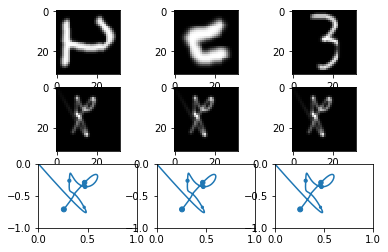

In [17]:
tf.compat.v1.reset_default_graph()
keras.backend.clear_session()
try:
    del model
except:
    pass

num_filter = 32; std = 1
section = 4; num_points = 30; lam = 1e-2
lam_sep = 1e-4; lam_len = 1e-3; lam_smooth = 1e-3
learning_rate = 1e-5
model = coding_net(num_filter, section, lam, std=std)
model_loss = total_loss(section,num_points,[lam_sep,lam_len,lam_smooth])
optimizer = tf.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=model_loss)
model.summary()

train = format_images(letter_data[:3,:,:])
outputs = model.predict(train)
kimg,xyv,para,_ = decode(outputs,section,num_points)
xpo,ypo,v = xyv
loc,_,_ = para
print(model_loss(train[:,:,:,0], outputs))
print(loc[0,:,0])
show_img(1,train[:,:,:,0], kimg,loc,xpo,ypo)
plt.show()

tf.Tensor(nan, shape=(), dtype=float32)
tf.Tensor([1. 1. 1. 1. 1.], shape=(5,), dtype=float32)


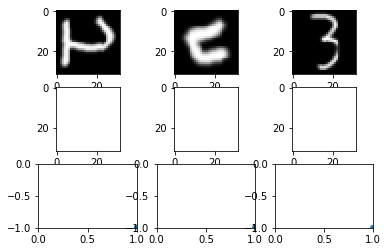

In [18]:
train = format_images(letter_data[:3,:,:])
model.train_on_batch(train,train[:,:,:,0])
outputs = model.predict(train)
kimg,xyv,para,_ = decode(outputs,section,num_points)
xpo,ypo,v = xyv
loc,_,_ = para
print(model_loss(train[:,:,:,0], outputs))
print(loc[0,:,0])
show_img(1,train[:,:,:,0], kimg,loc,xpo,ypo)
plt.show()

In [58]:
train = format_images(letter_train[:2000,:,:])
model.fit(train,train[:,:,:,0],epochs=3,batch_size=32,verbose=2)

Epoch 1/3
2000/2000 - 5s - loss: nan
Epoch 2/3
2000/2000 - 4s - loss: nan
Epoch 3/3
2000/2000 - 4s - loss: nan


Training
Sigma2: nan  Sigma2: nan  Sigma2: nan
tf.Tensor(
[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]], shape=(3, 4, 2), dtype=float32)


/home/bohao/.local/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/bohao/.local/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/bohao/.local/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bohao/.local/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bohao/.local/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/bohao/.local/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


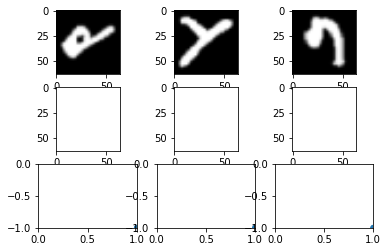

Sigma2: nan  Sigma2: nan  Sigma2: nan
tf.Tensor(
[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]], shape=(3, 4, 2), dtype=float32)


KeyboardInterrupt: 

In [59]:
def run_model(model, Xd, Xval,
              epochs=5, batch_size=64, print_every=100):

    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)    
    
    iter_cnt = 0
    fig = 1
    for e in range(epochs):
        losses = []
        val_losses = []
        for i in range(int(np.ceil(Xd.shape[0]/batch_size))):
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            Images = format_images(Xd[idx,:,:])
            model.train_on_batch(Images,Images[:,:,:,0])

            if (iter_cnt % print_every) == 0:
                ### show img
                val_ind = np.random.randint(0,3000,size=3)
                
                img_val = format_images(Xval[val_ind,:,:])
                
                outputs = model.predict(img_val)
                kimg,xyv,para,_ = decode(outputs, section,num_points)
                xpo,ypo,v = xyv
                loc,moment,sig2 = para
                print("Sigma2: {0:.5g}  Sigma2: {1:.5g}  Sigma2: {2:.5g}"\
                      .format(sig2[0],sig2[1],sig2[2]))
                print(loc)
                show_img(fig, img_val[:,:,:,0], kimg,loc,xpo,ypo)
                fig += 1
                plt.show()
                
            iter_cnt += 1
    return

with tf.device("/gpu:0"):
    print('Training')
    run_model(model,letter_train,letter_val,5,32,100)

In [ ]:
def run_model(session, total_loss, train_step, Xd, Xval, lr, 
              epochs=5, batch_size=64, print_every=100,
              plot_losses=True):

    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)    
    
    iter_cnt = 0
    fig = 1
    for e in range(epochs):
        losses = []
        val_losses = []
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            feed_dict = {X: Xd[idx,:,:],
                         Images: Xd[idx,:,:]}

            actual_batch_size = Xd[idx,:,:].shape[0]
            
            loss = session.run(total_loss, feed_dict=feed_dict)
            session.run(train_step, {X: Xd[idx,:,:],
                                     Images: Xd[idx,:,:],
                                     learning_rate: lr})
            
            ri = np.random.randint(0,5000,size=batch_size)
            val_dict = {X: Xval[ri,:,:],
                        Images: Xval[ri,:,:]}
            val_loss = session.run(total_loss, val_dict)
            
            losses.append(loss*actual_batch_size)
            val_losses.append(val_loss*actual_batch_size)
            
            # print every now and then
            if (iter_cnt % print_every) == 0:
                
                print("Iteration {0}: with minibatch training loss = {1:.3g} val loss = {2:.3g}"\
                      .format(iter_cnt,loss, val_loss))
                
                ### show img
                val_ind = np.random.randint(0,5000,size=3)
                
                feed_dict_val = {X: Xval[val_ind,:,:],
                                 Images: Xval[val_ind,:,:]}
                
                locations = session.run(loc, feed_dict_val)
                xpo, ypo = session.run([x_points, y_points], feed_dict_val)
                sig2_val = session.run(sig2, feed_dict_val)
                kimgs_val = session.run(kernel_imgs, feed_dict_val) 
                
                print("Sigma2: {0:.5g}  Sigma2: {1:.5g}  Sigma2: {2:.5g}"\
                      .format(sig2_val[0],sig2_val[1],sig2_val[2]))
                show_img(fig, Xval[val_ind,:,:], kimgs_val, locations, xpo,ypo)
                fig += 1
                plt.show()
                
            iter_cnt += 1
        mean_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0:.3g}"\
              .format(mean_loss,e+1))
        if e % 10 == 0:
            lr /= 10
            print("Learning Rate: {0:.3g}".format(lr))
        if plot_losses:
            plt.plot(losses,label='Train Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return mean_loss

sess = tf.Session()
with tf.device("/gpu:0"):
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess, total_loss, train_step, X_train,X_val, 1e-3, 10,64,200, True)